# Deep Convolutional GAN (DCGAN) with MNIST

This is a follow-up on [gan_mnist.ipynb](gan_mnist.ipynb).  It uses deep convolutional networks in the generator and the discriminator.

In [1]:
import numpy as np
from scipy.io import loadmat
import keras
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Loading MNIST Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

We only use the images not the categorical labels.

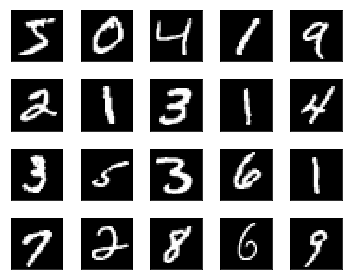

In [3]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Preprocessing and Deprocessing

As usual, we need preprocessing and later deprocessing of the images.  

As we will see later on, the generator is using `tanh` activation, for which we need to preprocess the image data into the range between -1 and 1.

In [4]:
def preprocess(x):    
    x = x.reshape(-1, 28, 28, 1) # 28,28,1
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

Apply the preprocessing on the train and test images (and they are the real images as oppose to the generated images).

In [5]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

## Generator

The original DCGAN paper [[3]](#ref3) proposes the following generator network architecture.

<img src='../images/dcgan_svhn/generator.png' width='70%'>

In this notebook, I used smaller networks than what the original paper [[3]](#ref3) uses.

It takes a latent sample of 100 random numbers and generates a 28x28 image with 1 channel.

In [gan_mnist.ipynb](gan_mnist.ipynb), I used a fully connected layer with 784 (=28x28) neurons.  To make this generator comparable, I use the same number of neurons in the first fully connected hidden layer, and then added transpose convolution layers afterwards.

In [6]:
def make_generator(input_size, leaky_alpha):
    # generates images in (28,28,1)
    return Sequential([
        Dense(784, input_shape=(input_size,)),
        Reshape(target_shape=(7, 7, 16)),                              # 7,7,16
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'), # 14,14,32
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'),  # 28,28,1
        Activation('tanh')
    ])

## Discriminator


The discriminator is a classifier to tell if the input image is real or fake.  

It is a convolutional neural network that takes a 28x28 image with 1 channel.  The values in the image is expected to be between -1 and 1.

The activation of the output layer is `sigmoid` and the discriminator outputs a probability of the image being real.

In [gan_mnist.ipynb](gan_mnist.ipynb), I used a fully connected layer with 784 (=28x28) neurons.  To make this discriminator comparable, I use the same number of neurons in the last fully connected hidden layer, and then added convolution layers beforehands.

Note: using the decreasing number of filters may be a bit unusual but I did this to make the discriminator network and the generator network to have same kind of increase in the number of convolutional network neurons (hopefully keeping their power in balance).

In [7]:
def make_discriminator(leaky_alpha):
    # classifies images in (28,28,1)
    return Sequential([        
        Conv2D(32, kernel_size=5, strides=2, padding='same',    # 14,14,32
               input_shape=(28,28,1)),
        LeakyReLU(alpha=leaky_alpha),
        Conv2D(16, kernel_size=5, strides=2, padding='same'),   # 7,7,16
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Flatten(),
        Dense(784),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Dense(1),
        Activation('sigmoid')        
    ])

### About Batch Normalization

As for the batch normalization, it was applied to most of the layers but not all.  The below is a quote from the original DCGAN paper [[3]](#ref3).

> Directly applying batchnorm to all layers, however, resulted in sample oscillation and model instability. This was avoided by not applying batchnorm to the generator output layer and the discriminator input layer.


## DCGAN

We connect the generator and the discriminator to make a DCGAN.

The input to the DCGAN is a latent sample.  The generator inside DCGAN produces an image which is fed into the discriminator inside the DCGAN.  So, the output of DCGAN is the probability of the generated image being real.

In [8]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
               g_learning_rate, 
               d_learning_rate,
               leaky_alpha):
    # generator
    generator = make_generator(sample_size, leaky_alpha)

    # discriminator
    discriminator = make_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator

## Training DCGAN

The below is a function to generate latent samples.

In [9]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

The below is a function to set the discriminator to trainable or non-trainable.

In [10]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

The below is a function to create a batch of labels.

In [11]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

The training DCGAN is essentially the same as training a simple GAN in [gan_mnist.ipynb](gan_mnist.ipynb).

* set the discriminator trainable
* train the discriminator with real images with the label smoothing   (labels=1-smooth)
* train the discriminator with fake images generated by the generator (labels=0)
* set the discriminator non-trainable
* train the DCGAN with generated images (labels=1)

We repeat this process many times until the discriminator loss and the generator loss stabilizes.

In [12]:
sample_size     = 100     # latent sample size (i.e. 100 random numbers)
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
leaky_alpha     = 0.01
epochs          = 100
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1

# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_DCGAN(
    sample_size, 
    g_learning_rate, 
    d_learning_rate,
    leaky_alpha)

losses = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
    
    # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))    

Epoch:   1/100 Discriminator Loss: 6.1034 Generator Loss: 1.3741
Epoch:   2/100 Discriminator Loss: 1.7829 Generator Loss: 1.0496
Epoch:   3/100 Discriminator Loss: 2.6401 Generator Loss: 1.3158
Epoch:   4/100 Discriminator Loss: 9.9313 Generator Loss: 9.5626
Epoch:   5/100 Discriminator Loss: 6.0627 Generator Loss: 6.1902
Epoch:   6/100 Discriminator Loss: 5.0648 Generator Loss: 3.3931
Epoch:   7/100 Discriminator Loss: 1.3909 Generator Loss: 1.2969
Epoch:   8/100 Discriminator Loss: 4.3349 Generator Loss: 4.5662
Epoch:   9/100 Discriminator Loss: 3.6264 Generator Loss: 4.3671
Epoch:  10/100 Discriminator Loss: 3.2477 Generator Loss: 2.4365
Epoch:  11/100 Discriminator Loss: 7.0162 Generator Loss: 6.5445
Epoch:  12/100 Discriminator Loss: 1.7893 Generator Loss: 0.6268
Epoch:  13/100 Discriminator Loss: 1.1098 Generator Loss: 1.6246
Epoch:  14/100 Discriminator Loss: 2.3767 Generator Loss: 3.1691
Epoch:  15/100 Discriminator Loss: 7.0090 Generator Loss: 4.8333
Epoch:  16/100 Discrimina

## Results

The discriminator loss and the generator loss are shown below.  They both kind of stabilizes in the end.

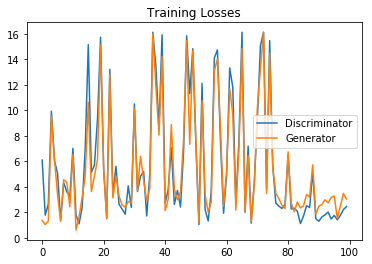

In [13]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

We can generate new images using the generator.

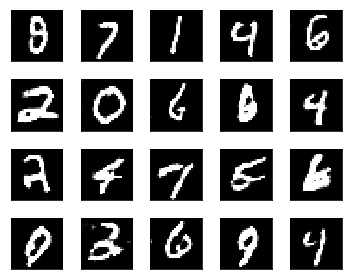

In [14]:
latent_samples = make_latent_samples(20, sample_size)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(5, 4))
for i in range(20):
    img = deprocess(generated_digits[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

It's definitely much better than the results from the simple GAN MNIST model in [gan_mnist.ipynb](gan_mnist.ipynb).

## References

<a id="ref1"></a>
### [1] MNIST dataset
 
Yann LeCun
 
http://yann.lecun.com/exdb/mnist/

<a id="ref2"></a>
### [2] Deep Convolutional GANs

Udacity

https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb

<a id="ref3"></a>
### [3] Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

Alec Radford & Luke Metz (indico Research), Soumith Chintala (Facebook AI Research)

https://arxiv.org/pdf/1511.06434.pdf